# An Implementation of Echo State Network in PyTorch
Amirabbas Asadi, amir137825@gmail.com

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

## Creating A Simple Regression Data

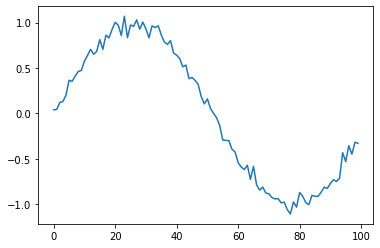

In [ ]:
X = torch.linspace(0, 1, 100)
y = torch.sin(6.0*X) + 0.05*torch.randn_like(X)
_ = plt.plot(y)

## Reservoir Network

In [ ]:
class Reservoir(nn.Module):
  def __init__(self, hidden_dim, connectivity):
    super().__init__()
    
    self.Wx = self.sparse_matrix(hidden_dim, connectivity)
    self.Wh = self.sparse_matrix(hidden_dim, connectivity)
    self.Uh = self.sparse_matrix(hidden_dim, connectivity)
    self.act = nn.Tanh()

  def sparse_matrix(self, m, p):
    mask_distribution = torch.distributions.Bernoulli(p)
    S = torch.randn((m, m))
    mask = mask_distribution.sample(S.shape)
    S = (S*mask).to_sparse()
    return S

  def forward(self, x, h):
    h = self.act(torch.sparse.mm(self.Uh, h.T).T +
                 torch.sparse.mm(self.Wh, x.T).T)
    y = self.act(torch.sparse.mm(self.Wx, h.T).T)

    return y, h

## Echo State Network

In [ ]:
class EchoState(nn.Module):
  def __init__(self, in_dim, out_dim, reservoir_dim, connectivity):
    super().__init__()

    self.reservoir_dim = reservoir_dim
    self.input_to_reservoir = nn.Linear(in_dim, reservoir_dim)
    self.input_to_reservoir.requires_grad_(False)

    self.reservoir = Reservoir(reservoir_dim, connectivity)
    self.readout = nn.Linear(reservoir_dim, out_dim)
  
  def forward(self, x):
    reservoir_in = self.input_to_reservoir(x)
    h = torch.ones(x.size(0), self.reservoir_dim)
    reservoirs = []
    for i in range(x.size(1)):
      out, h = self.reservoir(reservoir_in[:, i, :], h)
      reservoirs.append(out.unsqueeze(1))
    reservoirs = torch.cat(reservoirs, dim=1)
    outputs = self.readout(reservoirs)
    return outputs

## Training the model
we only need to train the last layer

In [ ]:
model = EchoState(in_dim=1, out_dim=1, reservoir_dim=128, connectivity=0.05)
optimizer = torch.optim.Adam(model.readout.parameters(), lr=0.02)
loss_fn = nn.MSELoss()

In [ ]:
epochs = 100
for epoch in range(epochs):
  optimizer.zero_grad()
  y_pred = model(X.view(1, -1, 1))
  loss = loss_fn(y_pred.squeeze(), y)
  loss.backward()
  optimizer.step()
  print(loss.item())

0.7701162099838257
1.196458101272583
0.511161744594574
0.2495274692773819
0.5351395606994629
0.4610131084918976
0.19651708006858826
0.17110416293144226
0.3226008713245392
0.33410152792930603
0.20049113035202026
0.13059097528457642
0.19515514373779297
0.25469231605529785
0.20490168035030365
0.1172800287604332
0.09987965226173401
0.14338868856430054
0.15616115927696228
0.11204849928617477
0.07502100616693497
0.09087648242712021
0.12279993295669556
0.1166682243347168
0.08274400979280472
0.06906598806381226
0.08472481369972229
0.09282337129116058
0.07424578070640564
0.05426151305437088
0.056787945330142975
0.06764312088489532
0.06270163506269455
0.047788701951503754
0.04469263181090355
0.05359535291790962
0.05580190196633339
0.04695511981844902
0.04153374582529068
0.04547346010804176
0.04748743399977684
0.04116962105035782
0.03552572429180145
0.037260331213474274
0.03958965837955475
0.03627360984683037
0.032465189695358276
0.033538591116666794
0.03527538850903511
0.03301936015486717
0.0302

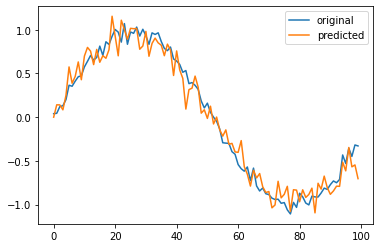

In [ ]:
with torch.no_grad():
  y_pred = model(X.view(1, -1, 1)).squeeze()

plt.plot(y, label='original')
plt.plot(y_pred.detach().numpy(), label='predicted')
plt.legend()
_ = plt.show()